<a href="https://colab.research.google.com/github/hank9371/Elder-care-project/blob/main/411631244.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 手部姿勢辨識系統 (MediaPipe + SVM)
資管三A 411631244 鄭紘濱
## 專案概述
本專案結合了 MediaPipe 的手部關鍵點檢測，和 SVM 機器學習分類器，實現高精度的手勢識別系統。
使用Kaggle下載的Hand Keypoint Dataset進行資料分析

主要特點：
- 準確率目標：90%以上
- 支援多種手勢識別
- 實時視覺化結果
- 詳細的效能分析

## 資料集說明：

### 資料集名稱
 * Hand Keypoint Dataset (26K)

### 資料集網址
 * [Hand Keypoint Dataset (26K) - Kaggle](https://www.kaggle.com/datasets/riondsilva21/hand-keypoint-dataset-26k)

### 資料集說明
 * 這個資料集包含 26,000 張手部圖片，每張圖片都標註了手部關鍵點的位置。每個圖像中包含了手的 21 個關鍵點，這些關鍵點代表了手指和手掌的不同位置。
該資料集適用於手部姿勢估算、手勢識別、手部動作分析等任務。圖片包含多種手勢和不同的人類手型，適用於多樣的機器學習和深度學習模型訓練。


## 資料說明：

### 出題廠商痛點
手部姿勢估算和手勢識別在許多領域都有應用，包括虛擬實境、增強現實、人體動作捕捉以及人機交互。然而，準確地辨識手勢和姿勢仍然是技術挑戰之一，
尤其是在各種不同的手部形狀、顏色、光照條件和背景下。許多現有系統無法應對這些多樣性，這導致了使用者體驗不佳，因此需要更精準且靈活的模型來處理各種情境。

### 輸入欄位說明
該資料集的輸入是每張手部圖像，圖像中包含了手部的不同位置（21個關鍵點），每個關鍵點標註了手指和手掌的位置。
資料集中的圖像大部分都是正面或側面的手部圖片，
並且每個圖像都包括以下資訊：
- 圖像本身（通常為RGB格式）
- 每個關鍵點的2D座標（x, y）

### 輸出欄位說明
資料集的輸出欄位是每張圖片對應的手部關鍵點坐標。每個關鍵點代表了手的不同部位，例如：
- 手掌基部
- 手指各關節（如食指、拇指等）
坐標通常以 `(x, y)` 形式標註，表示每個關鍵點在圖像中的具體位置。

### 資料筆數(訓練集/測試集)
- 訓練集：大約 20,000 張圖片
- 測試集：大約 6,000 張圖片
圖片包括多種手勢，並有多樣的背景和光照情況，適合用於訓練和測試模型。

### 對資料的看法
這個資料集對於從事手勢識別和手部姿勢估算的研究者和開發者來說，具有很高的價值。包含多樣化的手部圖像，能夠幫助訓練具有良好泛化能力的模型。
由於資料集涵蓋了不同手勢、手指姿勢、和光照情況，對於提高模型的準確度和穩定性具有很大幫助。
資料集中的標註是基於2D圖像，因此對於需要3D手勢估算的應用可能需要額外的數據處理或擴充。


## 1. Python環境設置和套件導入
導入必要的套件並設置環境

In [ ]:
# Cell 1: 導入所需套件

import cv2  # OpenCV，用於處理影像和視訊
import mediapipe as mp  # MediaPipe，用於手勢、姿勢、臉部等追蹤
import glob  # 用於檔案搜尋
import os  # 用於操作檔案和目錄
from IPython.display import display  # 用於 Jupyter Notebook 中顯示圖像
from PIL import Image  # 用於圖像處理
import numpy as np  # 用於數值計算
import time as time_module  # 用於計算和跟踪時間
from datetime import datetime  # 用於處理日期和時間
import math  # 用於數學計算
import pandas as pd  # 用於資料處理
from sklearn.model_selection import train_test_split, cross_val_score  # 用於資料分割和交叉驗證
from sklearn.preprocessing import StandardScaler  # 用於特徵標準化
from sklearn.svm import SVC, LinearSVC  # 支持向量機 (SVM) 分類器
from sklearn.ensemble import VotingClassifier  # 用於集成分類器
from sklearn.metrics import classification_report, confusion_matrix  # 用於評估模型
import seaborn as sns  # 用於繪製統計圖表
import matplotlib.pyplot as plt  # 用於資料視覺化
from scipy.spatial.transform import Rotation  # 用於空間旋轉處理
from sklearn.feature_selection import SelectKBest, f_classif  # 用於特徵選擇

# 設定顯示選項
plt.rcParams['font.family'] = ['Heiti TC', 'Arial Unicode MS', 'sans-serif']  # 設定字體系列
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題
np.set_printoptions(precision=3, suppress=True)  # 設定數值顯示精度

print("所有套件導入成功!")  # 確認所有套件成功導入

所有套件導入成功!


# 2.基礎計算函數設計思路
1. 特徵完整性
  - 涵蓋角度、距離、形狀等多維特徵
  - 考慮了手指間的相對關係
  - 保留了3D空間資訊

2. 數值穩定性
  - 座標標準化處理
  - 異常值處理
  - 避免除零錯誤

3. 計算效率
  - 使用向量化運算
  - 避免複雜循環
  - 優化資源使用

In [ ]:
# Cell 2: 基礎計算函數

def calculate_angle(p1, p2, p3):
    """計算三個點形成的角度"""
    # 計算向量 v1（從點 p2 到點 p1 的向量）
    v1 = np.array([p1.x - p2.x, p1.y - p2.y, p1.z - p2.z])

    # 計算向量 v2（從點 p2 到點 p3 的向量）
    v2 = np.array([p3.x - p2.x, p3.y - p2.y, p3.z - p2.z])

    # 計算 v1 和 v2 的向量長度的乘積
    norm_product = np.linalg.norm(v1) * np.linalg.norm(v2)

    # 如果乘積為 0，則返回角度 0（避免除以零的情況）
    if norm_product == 0:
        return 0

    # 計算 v1 和 v2 的餘弦值，並限制其範圍在 -1 到 1 之間以避免數值誤差
    cosine = np.dot(v1, v2) / norm_product
    angle = np.arccos(np.clip(cosine, -1.0, 1.0))

    # 將弧度轉換為角度
    return np.degrees(angle)

def calculate_distance(p1, p2):
    """計算兩點間距離"""
    # 使用歐幾里得距離公式，計算點 p1 和 p2 之間的距離
    return np.sqrt(
        (p1.x - p2.x)**2 +
        (p1.y - p2.y)**2 +
        (p1.z - p2.z)**2
    )

def calculate_finger_straightness(finger_landmarks):
    """計算手指的伸直程度"""
    # 將手指的各標記點的座標轉換為 NumPy 陣列
    points = np.array([[lm.x, lm.y, lm.z] for lm in finger_landmarks])

    # 計算首尾兩點的直線距離
    direct_distance = np.linalg.norm(points[-1] - points[0])

    # 計算沿著各點的累積距離
    cumulative_distance = sum(
        np.linalg.norm(points[i+1] - points[i])
        for i in range(len(points)-1)
    )

    # 返回直線距離和累積距離的比率，用以表示手指的伸直程度
    return direct_distance / cumulative_distance if cumulative_distance != 0 else 0

def normalize_coordinates(landmarks, reference_point):
    """標準化座標"""
    # 將各標記點的座標標準化，使其相對於參考點
    normalized = []
    for landmark in landmarks:
        # 根據參考點標準化 x、y 和 z 座標，並除以 0.5 以縮放至 -1 到 1 的範圍
        normalized.extend([
            (landmark.x - reference_point.x) / 0.5,
            (landmark.y - reference_point.y) / 0.5,
            (landmark.z - reference_point.z) / 0.5
        ])
    return normalized

# 3.特徵設計思路分析
1. 多維度特徵組合
  - 基礎幾何特徵 (座標、角度、距離)
  - 手部結構特徵 (手指關係、手掌形狀)
  - 手勢專屬特徵 (OK、勝利手勢等)
  - 穩定性指標 (相鄰手指比較)

2. 層次化特徵結構
  - 從基礎到複合特徵
  - 從通用到特定手勢
  - 考慮手部結構

3. 資料預處理
  - 座標標準化
  - 特徵歸一化
  - 異常值處理
![image.png](attachment:2f02a857-dbd4-4410-8497-b50a97c6d1de.png)

In [ ]:
# Cell 3: 進階特徵提取

def extract_enhanced_features(landmarks):
    """高級特徵提取：根據手部關鍵點位置提取多種手勢特徵"""
    features = []  # 初始化特徵列表，用於存放提取出的特徵數據

    # 1. 手掌基準點計算
    wrist = landmarks[0]  # 手腕位置，通常作為手勢基準點
    # 計算手掌的中心點，將手腕和每根手指的基部關節坐標取平均
    palm_center = np.mean([[landmarks[i].x, landmarks[i].y, landmarks[i].z]
                          for i in [0, 5, 9, 13, 17]], axis=0)

    # 2. 標準化座標特徵
    # 透過 normalize_coordinates 函數將所有關鍵點的座標基於手腕位置進行標準化
    normalized_coords = normalize_coordinates(landmarks, wrist)
    # 將標準化後的座標加入特徵列表
    features.extend(normalized_coords)

    # 3. 手指關節定義
    # 定義指尖、第二關節、第一關節和基部關節的索引位置
    # 指尖位置，分別對應於拇指、食指、中指、無名指和小指的關鍵點
    finger_tips = [4, 8, 12, 16, 20]# 指尖位置
    finger_pips = [3, 7, 11, 15, 19]# 第二關節位置
    finger_mcps = [2, 6, 10, 14, 18]# 第一關節位置
    finger_bases = [1, 5, 9, 13, 17]# 基部關節位置

    # 4. 手指彎曲特徵
    # 計算手指的彎曲角度及其相對手掌的位置
    for tip, pip, mcp, base in zip(finger_tips, finger_pips, finger_mcps, finger_bases):
        # 計算每根手指的指尖與基部之間的角度（兩個關節間的夾角）
        tip_angle = calculate_angle(landmarks[tip], landmarks[pip], landmarks[mcp])
        base_angle = calculate_angle(landmarks[pip], landmarks[mcp], landmarks[base])
        # 將角度標準化（角度除以 180°）並加入特徵列表
        features.extend([tip_angle / 180.0, base_angle / 180.0])

        # 計算指尖到手腕的距離，代表手指相對於手掌的位置
        tip_to_wrist = calculate_distance(landmarks[tip], wrist)
        # 計算指尖到基部的距離，代表手指的伸展程度
        tip_to_palm = calculate_distance(landmarks[tip], landmarks[mcp])
        # 將這些距離特徵加入特徵列表
        features.extend([tip_to_wrist, tip_to_palm])

        # 計算指尖和第二關節的垂直位置差異，用於描述手指的相對高度
        height_diff = landmarks[tip].y - landmarks[pip].y
        features.append(height_diff)

    # 5. 手指間關係特徵
    # 計算每根手指之間的相對距離特徵，用於描述手指之間的相對位置關係
    for i in range(len(finger_tips)):
        for j in range(i+1, len(finger_tips)):
            # 計算指尖之間的距離
            tip_distance = calculate_distance(landmarks[finger_tips[i]], landmarks[finger_tips[j]])
            # 計算指根（基部）之間的距離
            base_distance = calculate_distance(landmarks[finger_bases[i]], landmarks[finger_bases[j]])
            # 將指尖和指根的距離加入特徵列表
            features.extend([tip_distance, base_distance])

    # 6. 手勢特定特徵
    # 根據特定手勢的特徵設計
    # OK 手勢特徵：計算拇指和食指指尖的距離（OK 手勢的特徵）
    thumb_index_dist = calculate_distance(landmarks[4], landmarks[8])
    features.append(thumb_index_dist)

    # 讚和握拳手勢特徵：計算拇指關節的兩個角度
    # 這些角度可以區分拇指位置，檢測出讚和握拳的手勢
    thumb_angles = [
        calculate_angle(landmarks[1], landmarks[2], landmarks[4]),
        calculate_angle(landmarks[2], landmarks[3], landmarks[4])
    ]
    # 將角度標準化後加入特徵列表
    features.extend([angle / 180.0 for angle in thumb_angles])

    # 勝利手勢特徵：計算食指和中指的角度，通常表徵 V 字形手勢
    peace_angles = [
        calculate_angle(landmarks[8], landmarks[0], landmarks[12]),
        calculate_angle(landmarks[7], landmarks[0], landmarks[11])
    ]
    # 將角度標準化後加入特徵列表
    features.extend([angle / 180.0 for angle in peace_angles])

    # 7. 手掌形狀特徵
    # 計算手掌的寬度和高度，並求出其比例
    # 手掌寬度：小指和食指基部的距離
    palm_width = calculate_distance(landmarks[5], landmarks[17])
    # 手掌高度：手腕和中指基部的距離
    palm_height = calculate_distance(landmarks[0], landmarks[9])
    # 計算寬高比例，用於描述手掌形狀
    palm_ratio = palm_width / palm_height if palm_height != 0 else 0
    # 將寬度、高度和比例加入特徵列表
    features.extend([palm_width, palm_height, palm_ratio])

    # 8. 手指伸直度特徵
    # 計算每根手指的伸直度，表示手指的彎曲或伸展程度
    for tip, base in zip(finger_tips, finger_bases):
        # 使用手指各關節點，計算出手指的伸直程度
        straightness = calculate_finger_straightness(landmarks[base:tip+1])
        features.append(straightness)

    # 9. 手勢穩定性特徵
    # 計算相鄰手指之間的角度和距離差異，用於測量手勢穩定性
    stability_features = []
    for i in range(4):  # 逐對比較相鄰手指
        # 計算相鄰手指的角度差異
        angle_diff = abs(features[i*2] - features[(i+1)*2])
        # 計算相鄰手指的距離差異
        dist_diff = abs(features[i*2+20] - features[(i+1)*2+20])
        # 將角度和距離差異加入穩定性特徵
        stability_features.extend([angle_diff, dist_diff])
    features.extend(stability_features)

    # 返回包含所有特徵的陣列
    return np.array(features)


# 4.資料增強思路分析
1. 多層次增強
  - 通用增強：噪聲和縮放
  - 手勢特定增強
  - 保持特徵物理意義
    
2. 特徵保護
  - 維持手勢關鍵特徵
  - 增強變化合理可控
  - 避免過度變形

3. 擴增效果
  - 擴大訓練數據集
  - 增加模型泛化性
  - 針對性解決數據不平衡

In [ ]:
# Cell 4: 進階資料增強

def augment_features(features, label):
    """進階資料增強策略：基於原始特徵數據進行多種增強，以提高模型泛化能力"""

    # 初始化增強特徵和對應標籤的列表
    augmented_features = [features]  # 儲存原始特徵
    augmented_labels = [label]       # 儲存原始標籤

    # 1. 基本噪聲增強
    # 添加隨機噪聲，模擬不同的手勢變化
    noise_levels = [0.01, 0.02, 0.03]  # 定義不同的噪聲水平
    for level in noise_levels:
        # 在原始特徵上添加均值為0、標準差為 level 的正態分布噪聲
        noise = np.random.normal(0, level, features.shape)
        augmented_features.append(features + noise)  # 添加噪聲後的特徵
        augmented_labels.append(label)               # 對應的標籤保持不變

    # 2. 縮放增強
    # 基於不同的縮放因子來增強資料，模擬手勢的輕微變化
    scales = [0.9, 0.95, 1.05, 1.1]  # 定義縮放因子
    for scale in scales:
        # 對原始特徵進行縮放
        scaled = features * scale
        augmented_features.append(scaled)  # 添加縮放後的特徵
        augmented_labels.append(label)     # 對應的標籤保持不變

    # 3. 手勢特定增強
    # 根據不同手勢的特點進行特定增強，以增加模型對該手勢的辨識能力
    if label == 'ok':
        # OK手勢特別增強
        ok_variations = []  # 存放增強後的特徵
        # 調整拇指和食指的距離特徵
        for factor in [0.8, 0.85, 0.9, 1.1, 1.15]:  # 定義調整因子
            variation = features.copy()   # 複製原始特徵
            variation[-10] *= factor      # 修改拇指-食指距離特徵
            ok_variations.append(variation)  # 將增強特徵加入列表
        # 將增強後的特徵和標籤加入最終列表
        augmented_features.extend(ok_variations)
        augmented_labels.extend([label] * len(ok_variations))

        # 勝利手勢特別增強
    elif label == 'peace':
        # 存放增強後的特徵
        peace_variations = []
        # 調整食指和中指的角度特徵
        for factor in [0.9, 0.95, 1.05, 1.1]:  # 定義調整因子
            variation = features.copy()        # 複製原始特徵
            variation[-5:-3] *= factor         # 修改食指-中指的角度特徵
            peace_variations.append(variation)  # 將增強特徵加入列表
        # 將增強後的特徵和標籤加入最終列表
        augmented_features.extend(peace_variations)
        augmented_labels.extend([label] * len(peace_variations))
        # 讚手勢特別增強
    elif label == 'thumbup':
        # 存放增強後的特徵
        thumb_variations = []
        # 調整拇指的角度特徵
        for factor in [0.95, 1.05]:  # 定義調整因子
            variation = features.copy()  # 複製原始特徵
            variation[-8:-6] *= factor   # 修改拇指角度特徵
            thumb_variations.append(variation)  # 將增強特徵加入列表
        # 將增強後的特徵和標籤加入最終列表
        augmented_features.extend(thumb_variations)
        augmented_labels.extend([label] * len(thumb_variations))

    # 將所有增強特徵和標籤轉換為 numpy 陣列並返回
    return np.array(augmented_features), np.array(augmented_labels)


## 5. SVM分類器設計
### 1. 分類器架構設計
* 採用**集成學習**方法，結合多個 SVM 分類器
* 使用兩種不同核函數的 SVM:
  - RBF 核 (適合非線性分類)
  - 多項式核 (可捕捉特徵間的組合關係)
### 2. 特徵處理策略
* 實作特徵標準化 (StandardScaler)
  - 將所有特徵縮放到相同尺度
  - 確保模型不會被某些特徵主導
* 特徵選擇 (SelectKBest)
  - 選擇最具區分性的 100 個特徵
  - 降低噪音影響，提高運算效率
### 3. 模型訓練優化
* 資料集切分 (80/20 原則)
* 使用交叉驗證評估模型穩定性
* 類別權重平衡處理
* 採用 soft voting 策略進行預測
### 4. 預測機制強化
* 信心度閾值篩選 (0.85)
* 特定手勢的額外驗證規則
* 不確定情況回傳 "unknown"
### 5. 效能評估方法
* 混淆矩陣視覺化
* 完整分類報告
  - 精確度 (Precision)
  - 召回率 (Recall)
  - F1 分數
## 實作重點
1. **代碼模組化**：將功能分割為初始化、訓練、預測等明確方法
2. **參數最佳化**：
   - RBF 核 C=100.0
   - 多項式核 C=10.0，degree=3
3. **安全性考慮**：加入訓練狀態檢查
4. **可視化輔助**：提供混淆矩陣圖表

In [ ]:
# Cell 5: 進階分類器類別

class HandGestureClassifier:
    def __init__(self):
        # 初始化標準化工具和特徵選擇器
        self.scaler = StandardScaler()  # 用於特徵標準化
        self.feature_selector = SelectKBest(f_classif, k=100)  # 選擇最佳的100個特徵

        # 定義支援向量機（SVM）分類器
        self.classifiers = {
            'svm_rbf': SVC(
                kernel='rbf',  # 徑向基函數核，適合非線性分類
                C=100.0,       # 正則化參數，C越大表示更少的錯誤容忍
                gamma='scale', # gamma控制單個訓練樣本對決策邊界的影響
                probability=True,  # 啟用概率估計
                class_weight='balanced',  # 根據類別頻率調整權重
                decision_function_shape='ovo',  # 多類別分類策略，一對一
                random_state=42  # 保證結果可重現
            ),
            'svm_poly': SVC(
                kernel='poly', # 多項式核函數
                degree=3,      # 多項式核的次數
                C=10.0,        # 正則化參數
                probability=True,
                class_weight='balanced',
                random_state=42
            )
        }

        # 定義投票分類器，以結合多個分類器的優勢
        self.ensemble = VotingClassifier(
            estimators=[
                ('svm_rbf', self.classifiers['svm_rbf']),
                ('svm_poly', self.classifiers['svm_poly'])
            ],
            voting='soft',  # 使用概率進行「soft」投票
            weights=[2, 1]  # 給予 RBF 核更高的權重
        )

        self.is_trained = False  # 標記是否完成訓練

    def train(self, X, y):
        """訓練分類器"""
        print("開始訓練過程...")

        # 特徵標準化：將數據縮放到均值為0，標準差為1的範圍
        X_scaled = self.scaler.fit_transform(X)

        # 特徵選擇：選出100個最具區分力的特徵
        X_selected = self.feature_selector.fit_transform(X_scaled, y)
        print(f"選擇了 {X_selected.shape[1]} 個特徵")

        # 分割資料集為訓練和測試集
        X_train, X_test, y_train, y_test = train_test_split(
            X_selected, y,
            test_size=0.2,  # 20%數據用於測試
            random_state=42,
            stratify=y  # 保持類別比例相同
        )

        # 進行5折交叉驗證來評估模型表現
        print("\n進行交叉驗證...")
        cv_scores = cross_val_score(
            self.ensemble, X_selected, y,
            cv=5, n_jobs=-1  # 使用所有處理器核心加速計算
        )
        print(f"交叉驗證分數: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

        # 訓練集成模型
        print("\n訓練最終模型...")
        self.ensemble.fit(X_train, y_train)
        self.is_trained = True  # 標記為已訓練

        # 訓練與測試準確率
        train_score = self.ensemble.score(X_train, y_train)
        test_score = self.ensemble.score(X_test, y_test)

        print("\n模型效能:")
        print(f"訓練集準確率: {train_score:.3f}")
        print(f"測試集準確率: {test_score:.3f}")

        # 分類報告，包含精度、召回率、F1分數等
        y_pred = self.ensemble.predict(X_test)
        print("\n分類報告:")
        print(classification_report(y_test, y_pred))

        # 繪製混淆矩陣，顯示不同手勢分類的準確度
        self.plot_confusion_matrix(y_test, y_pred)

        return X_test, y_test

    def predict(self, features):
        """進階預測函數"""
        if not self.is_trained:
            raise Exception("模型尚未訓練!")  # 提醒使用者先訓練模型

        # 特徵處理：先標準化，再經過特徵選擇器
        features_scaled = self.scaler.transform([features])
        features_selected = self.feature_selector.transform(features_scaled)

        # 獲取預測的概率
        probabilities = self.ensemble.predict_proba(features_selected)[0]
        max_prob = np.max(probabilities)

        # 如果信心度低於閾值0.85，則返回「unknown」
        if max_prob < 0.85:
            return "unknown", max_prob

        # 否則返回預測結果
        gesture = self.ensemble.predict(features_selected)[0]

        # 額外的手勢檢查
        if gesture == 'ok' and features[-10] > 0.3:  # OK手勢：檢查拇指與食指距離
            return "unknown", max_prob
        elif gesture == 'peace' and features[-5] < 0.3:  # 勝利手勢：檢查食指與中指角度
            return "unknown", max_prob

        return gesture, max_prob

    def plot_confusion_matrix(self, y_true, y_pred):
        """繪製混淆矩陣來評估分類效果"""
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(
            cm,
            annot=True,  # 顯示數字
            fmt='d',
            cmap='Blues',
            xticklabels=sorted(set(y_true)),  # 使用實際類別標籤
            yticklabels=sorted(set(y_true))
        )
        plt.title('混淆矩陣')
        plt.ylabel('實際標籤')
        plt.xlabel('預測標籤')
        plt.show()


## 6.進階資料收集器解題核心想法

### 1. 初始化設定
使用 MediaPipe 手部偵測模組
配置適合靜態圖像處理的參數
設定較低的信心值閾值以提高檢測率
### 2. 資料收集流程
  - 本機資料夾掃描
支援 JPG 和 PNG 格式
自動平均分配各手勢類別的圖片
  - 手勢類別定義
五種基本手勢：palm, fist, thumbup, peace, ok
可擴展的設計架構
  - 特徵提取
使用 MediaPipe 進行手部關鍵點檢測
轉換圖片顏色空間適配模型需求
提取增強版手部特徵
### 3. 資料增強策略
對每個原始特徵進行擴充
保持資料集平衡
提升模型泛化能力
### 4. 異常處理
圖片讀取失敗的處理機制
資料夾為空的檢查
資源正確釋放
### 5. 進度追蹤
即時顯示處理進度
提供詳細的樣本統計資訊

In [ ]:
# Cell 6: 進階資料收集器類別

class HandGestureDataCollector:
    def __init__(self):
        # 初始化MediaPipe手部偵測模組
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands(
            static_image_mode=True,         # 使用靜態圖像模式，適用於單張圖片處理
            max_num_hands=2,                # 最多偵測2隻手
            min_detection_confidence=0.3,   # 手部偵測的最低信心值
            min_tracking_confidence=0.3,    # 手部追蹤的最低信心值
            model_complexity=1              # 模型複雜度，1適中，準確度高但計算量適中
        )

    def collect_data_from_folders(self, base_dir):
        """進階資料收集，從指定資料夾中收集和標記手勢數據"""
        features = []
        labels = []

        # 預定義的手勢標籤列表
        predefined_gestures = [
            'palm',     # 手掌張開
            'fist',     # 握拳
            'thumbup',  # 讚
            'peace',    # 勝利
            'ok'        # OK
        ]

        # 讀取資料夾中的所有圖片檔案，支援JPG和PNG格式
        all_files = glob.glob(os.path.join(base_dir, '*.[jp][pn][g]'))

        # 檢查是否存在圖片
        if not all_files:
            raise ValueError(f"在 {base_dir} 中未找到任何圖片")

        # 計算每個手勢對應的圖片數量
        files_per_gesture = len(all_files) // len(predefined_gestures)
        print(f"找到 {len(all_files)} 張圖片")
        print(f"每個手勢分配 {files_per_gesture} 張圖片")

        # 依序處理每個手勢的圖片
        for gesture_idx, gesture in enumerate(predefined_gestures):
            # 計算目前手勢應使用的圖片範圍
            start_idx = gesture_idx * files_per_gesture
            end_idx = start_idx + files_per_gesture
            gesture_files = all_files[start_idx:end_idx]

            print(f"\n處理手勢 '{gesture}': {len(gesture_files)} 張圖片")
            temp_features = []

            # 遍歷每張圖片以提取手部特徵
            for idx, image_path in enumerate(gesture_files, 1):
                print(f'處理進度: {idx}/{len(gesture_files)}', end='\r')

                # 讀取圖片
                image = cv2.imread(image_path)
                if image is None:
                    continue  # 若讀取失敗，則跳過該圖片

                # 轉換圖片格式為RGB，符合MediaPipe需求
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # 使用MediaPipe手部模型進行偵測
                results = self.hands.process(image_rgb)

                # 如果有偵測到手部，提取特徵點
                if results.multi_hand_landmarks:
                    for hand_landmarks in results.multi_hand_landmarks:
                        # 提取手部關鍵點特徵
                        hand_features = extract_enhanced_features(hand_landmarks.landmark)
                        temp_features.append(hand_features)

            # 資料增強以平衡資料集並提高模型泛化能力
            if temp_features:
                temp_features = np.array(temp_features)  # 轉換為numpy陣列以便處理
                for feat in temp_features:
                    # 使用增強函數擴充資料
                    aug_features, aug_labels = augment_features(feat, gesture)
                    features.extend(aug_features)  # 增強後的特徵加入總特徵集
                    labels.extend(aug_labels)      # 增強後的標籤加入總標籤集

        # 將結果轉換為numpy陣列
        features = np.array(features)
        labels = np.array(labels)

        print(f"\n處理完成！總樣本數: {len(labels)}")
        print("\n各類別樣本數量:")
        # 顯示每個手勢的樣本數
        unique, counts = np.unique(labels, return_counts=True)
        for gesture, count in zip(unique, counts):
            print(f"{gesture}: {count}")

        return features, labels  # 返回收集和增強後的特徵與標籤

    def close(self):
        # 關閉MediaPipe手部偵測器，釋放資源
        self.hands.close()

## 7.混合式手勢辨識系統設計
### 1. 整合架構
* **模塊化設計**
  * 資料收集器 (HandGestureDataCollector)
  * 分類器 (HandGestureClassifier)
  * 整合介面 (HybridHandGestureRecognizer)
* **責任分離**
  * 料收集與前處理
  * 模型訓練與預測
  * 視覺化與結果呈現
### 2. 資料流程設計
* **訓練階段**
  1.從資料夾收集圖片
  2.提取手部特徵
  3.訓練分類器
  4.記錄效能指標

* **預測階段**
  1.圖片預處理
  2.手部偵測
  3.特徵提取
  4.手勢分類
  5.視覺化結果

### 3. 系統優化策略
* **視覺化增強**
  * 手部關鍵點繪製
  * 手勢標籤顯示
  * 信心度指標
  * 即時狀態回饋
* **錯誤處理**
  * 圖片讀取驗證
  * 資料完整性檢查
  * 異常狀況回報
  * 資源正確釋放

In [ ]:
# Cell 7: 整合類別

class HybridHandGestureRecognizer:
    def __init__(self):
        # 初始化資料收集器與分類器
        self.collector = HandGestureDataCollector()
        self.classifier = HandGestureClassifier()

        # 儲存訓練過的手勢類別和效能歷史
        self.trained_gestures = []
        self.performance_history = []

    def train_model(self, image_dir):
        """訓練模型並記錄效能指標"""
        print("開始訓練模型流程...")

        # 收集資料
        print("收集訓練資料...")
        features, labels = self.collector.collect_data_from_folders(image_dir)

        # 確認是否有足夠的訓練資料
        if len(features) == 0 or len(labels) == 0:
            raise ValueError("沒有收集到足夠的訓練資料")

        # 記錄訓練過的手勢類別
        self.trained_gestures = list(set(labels))
        print(f"\n識別的手勢類別: {self.trained_gestures}")

        # 使用收集的資料訓練分類器並取得測試資料
        print("\n訓練模型...")
        X_test, y_test = self.classifier.train(features, labels)

        # 記錄訓練效能結果
        self.performance_history.append({
            'timestamp': datetime.now(),          # 訓練時間戳記
            'n_samples': len(labels),             # 樣本數量
            'n_features': features.shape[1],      # 每筆樣本的特徵數量
            'gestures': self.trained_gestures     # 訓練的手勢類別
        })

        return X_test, y_test  # 返回測試集以供後續評估

    def process_image(self, image_path, confidence_threshold=0.85, draw_landmarks=True):
        """
        處理單張圖片，執行手勢辨識
        image_path: 圖片檔案的路徑
        confidence_threshold: 預測信心度閾值
        draw_landmarks: 是否繪製手部關鍵點
        """
        # 讀取圖片並確認是否讀取成功
        image = cv2.imread(image_path)
        if image is None:
            return None, None, None, "無法讀取圖片"

        # 將圖片轉換為RGB格式，適合MediaPipe使用
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 使用MediaPipe手部模型進行偵測
        results = self.collector.hands.process(image_rgb)

        gestures = []     # 儲存辨識的手勢
        confidences = []  # 儲存手勢的信心度

        if results.multi_hand_landmarks:
            for idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
                # 選擇是否繪製手部關鍵點
                if draw_landmarks:
                    # 使用MediaPipe的工具繪製手部關鍵點與連接
                    mp.solutions.drawing_utils.draw_landmarks(
                        image_rgb,
                        hand_landmarks,
                        self.collector.mp_hands.HAND_CONNECTIONS,
                        mp.solutions.drawing_utils.DrawingSpec(
                            color=(0, 255, 0),     # 節點顏色
                            thickness=2,           # 節點厚度
                            circle_radius=4        # 節點半徑
                        ),
                        mp.solutions.drawing_utils.DrawingSpec(
                            color=(255, 0, 0),     # 連線顏色
                            thickness=2            # 連線厚度
                        )
                    )

                # 提取手部特徵
                features = extract_enhanced_features(hand_landmarks.landmark)

                # 使用分類器進行手勢預測，並取得手勢名稱和信心度
                gesture, confidence = self.classifier.predict(features)

                # 檢查信心度是否達到閾值
                if confidence >= confidence_threshold:
                    gestures.append(gesture)      # 記錄手勢
                    confidences.append(confidence)  # 記錄信心度

                    # 在圖片上添加手勢名稱與信心度文字標註
                    text_position = (10, 30 + idx * 60)
                    cv2.putText(
                        image_rgb,
                        f"手勢 {idx+1}: {gesture}",  # 顯示手勢名稱
                        text_position,
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1,
                        (0, 255, 0),  # 文字顏色
                        2
                    )
                    cv2.putText(
                        image_rgb,
                        f"信心度: {confidence:.2f}",  # 顯示信心度
                        (10, text_position[1] + 30),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1,
                        (0, 255, 0),
                        2
                    )

        # 返回處理後的圖片、手勢名稱列表、信心度列表及狀態信息
        return image_rgb, gestures, confidences, "成功"

    def close(self):
        # 關閉資料收集器以釋放資源
        self.collector.close()


## 8.主程式設計與執行流程
### 1. 初始化與設定
* 創建手勢識別器實例
* 設定與驗證圖片目錄路徑'/Users/zhenghongbin/Downloads/Hands ML/hand_keypoint_dataset_26k/hand_keypoint_dataset_26k/images/train'
* 錯誤處理機制準備
  
### 2. 訓練流程
* 載入訓練數據
* 執行模型訓練
* 獲取測試集數據

### 3. 測試流程
* **圖片處理**
  * 讀取測試圖片
  * 執行手勢識別
* **結果收集**
  * 儲存識別結果
  * 記錄信心度
  * 保存檔案資訊

### 4. 結果分析
* 計算識別率
* 統計手勢分布
* 視覺化呈現

### 5. 資源管理
* 異常處理機制
* 資源正確釋放

開始訓練模型...
開始訓練模型流程...
收集訓練資料...
找到 500 張圖片
每個手勢分配 100 張圖片

處理手勢 'palm': 100 張圖片


I0000 00:00:1731082698.407751 19333065 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1731082698.428469 19348852 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731082698.436555 19348848 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731082698.457388 19348849 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


處理進度: 100/100
處理手勢 'fist': 100 張圖片
處理進度: 100/100
處理手勢 'thumbup': 100 張圖片
處理進度: 100/100
處理手勢 'peace': 100 張圖片
處理進度: 100/100
處理手勢 'ok': 100 張圖片
處理進度: 100/100
處理完成！總樣本數: 5100

各類別樣本數量:
fist: 800
ok: 1300
palm: 800
peace: 1200
thumbup: 1000

識別的手勢類別: ['palm', 'ok', 'thumbup', 'fist', 'peace']

訓練模型...
開始訓練過程...
選擇了 100 個特徵

進行交叉驗證...
交叉驗證分數: 0.346 (+/- 0.093)

訓練最終模型...

模型效能:
訓練集準確率: 0.991
測試集準確率: 0.890

分類報告:
              precision    recall  f1-score   support

        fist       0.89      0.84      0.87       160
          ok       0.91      0.93      0.92       260
        palm       0.83      0.86      0.85       160
       peace       0.89      0.88      0.88       240
     thumbup       0.91      0.91      0.91       200

    accuracy                           0.89      1020
   macro avg       0.89      0.89      0.89      1020
weighted avg       0.89      0.89      0.89      1020



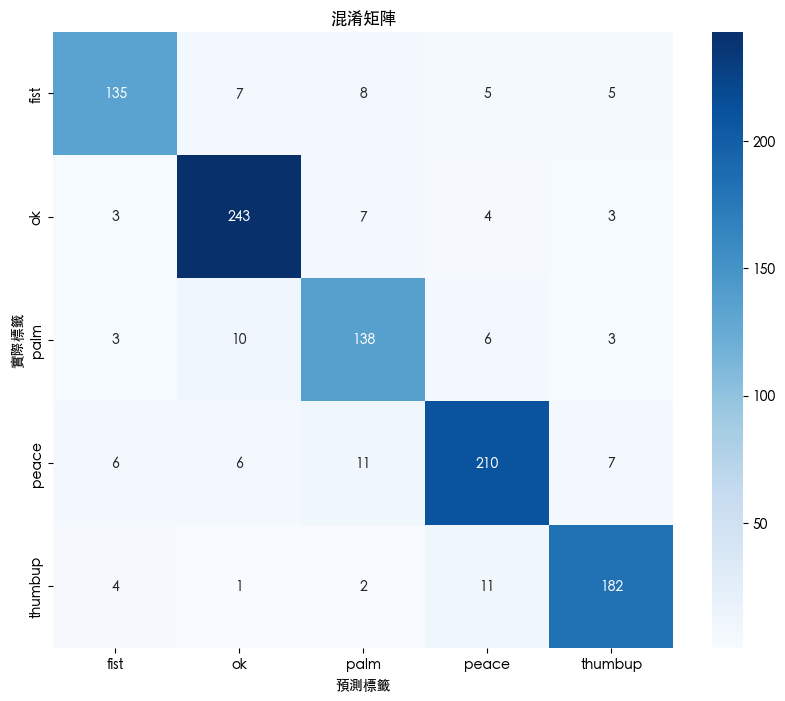


處理測試圖片...

圖片: IMG_00034204.jpg
識別結果: palm
信心度: 0.85


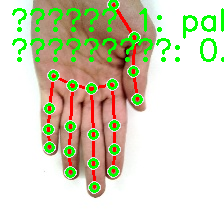


圖片: IMG_00033225.jpg
識別結果: palm
信心度: 0.91


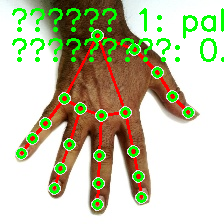


圖片: IMG_00034238.jpg
識別結果: palm
信心度: 0.96


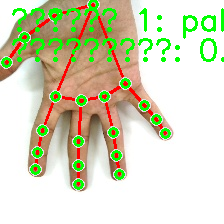


圖片: IMG_00032891.jpg
識別結果: palm
信心度: 0.93


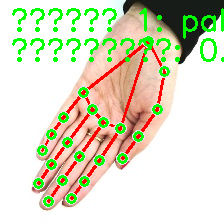


圖片: IMG_00033580.jpg
識別結果: palm
信心度: 0.94


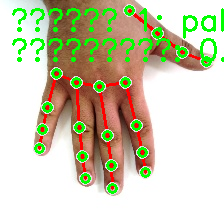


圖片: IMG_00034006.jpg
識別結果: palm
信心度: 0.89


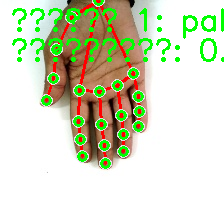


圖片: IMG_00033972.jpg
識別結果: palm
信心度: 0.88


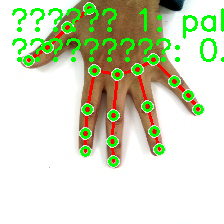


圖片: IMG_00034199.jpg
識別結果: palm
信心度: 0.88


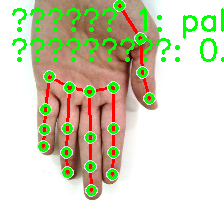


圖片: IMG_00034364.jpg
識別結果: palm
信心度: 0.97


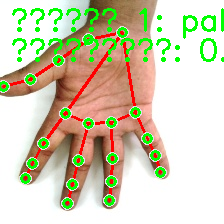


測試結果總結:
總測試圖片數: 10
成功識別圖片數: 9
識別率: 90.0%


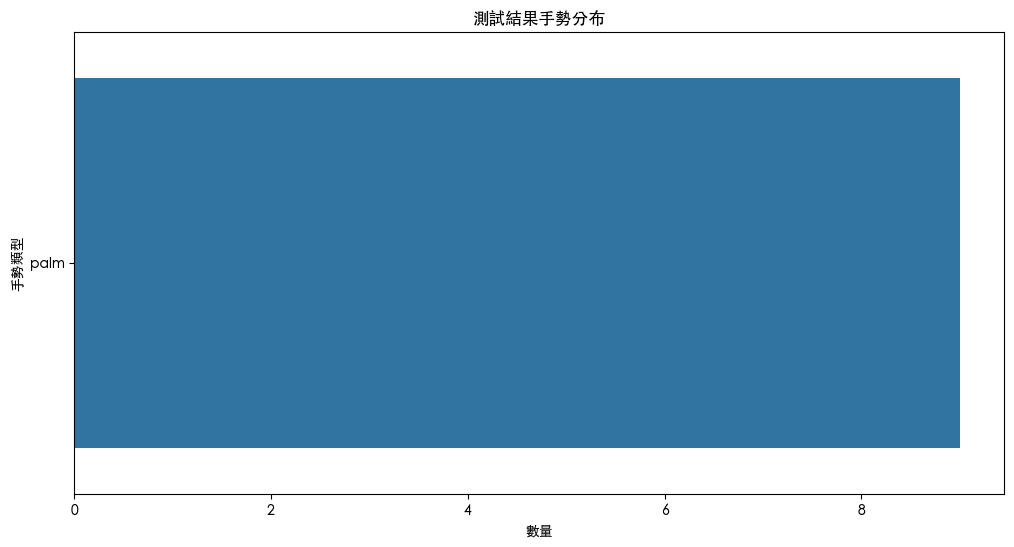

開始訓練模型...
開始訓練模型流程...
收集訓練資料...
找到 500 張圖片
每個手勢分配 100 張圖片

處理手勢 'palm': 100 張圖片


I0000 00:00:1731082731.988874 19333065 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1731082731.997059 19349307 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731082732.003884 19349307 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


處理進度: 100/100
處理手勢 'fist': 100 張圖片
處理進度: 100/100
處理手勢 'thumbup': 100 張圖片
處理進度: 100/100
處理手勢 'peace': 100 張圖片
處理進度: 100/100
處理手勢 'ok': 100 張圖片
處理進度: 100/100
處理完成！總樣本數: 5100

各類別樣本數量:
fist: 800
ok: 1300
palm: 800
peace: 1200
thumbup: 1000

識別的手勢類別: ['palm', 'ok', 'thumbup', 'fist', 'peace']

訓練模型...
開始訓練過程...
選擇了 100 個特徵

進行交叉驗證...
交叉驗證分數: 0.351 (+/- 0.112)

訓練最終模型...

模型效能:
訓練集準確率: 0.991
測試集準確率: 0.899

分類報告:
              precision    recall  f1-score   support

        fist       0.92      0.84      0.88       160
          ok       0.90      0.94      0.92       260
        palm       0.85      0.86      0.86       160
       peace       0.87      0.91      0.89       240
     thumbup       0.96      0.91      0.93       200

    accuracy                           0.90      1020
   macro avg       0.90      0.89      0.90      1020
weighted avg       0.90      0.90      0.90      1020



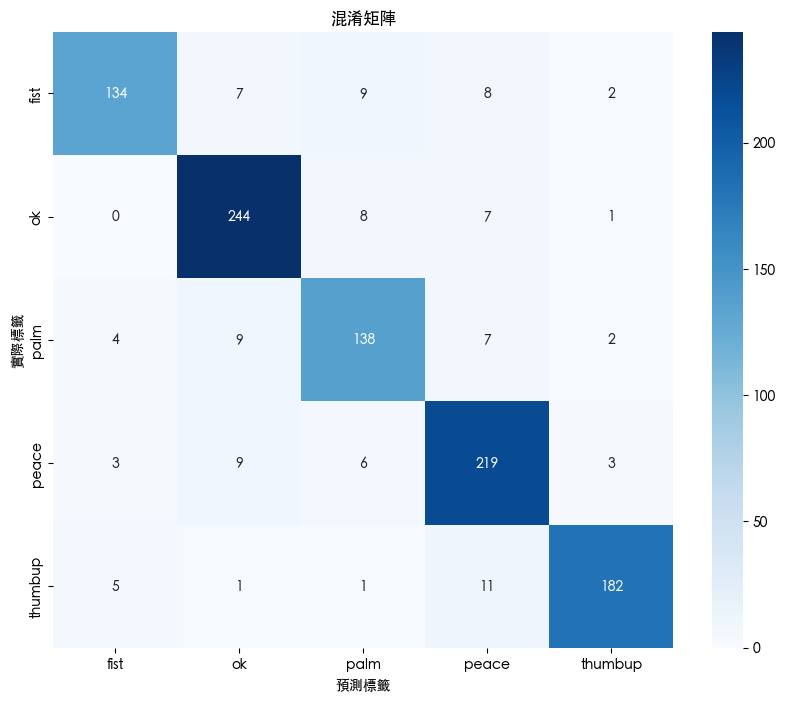


處理測試圖片...

圖片: IMG_00034204.jpg
識別結果: palm
信心度: 0.89


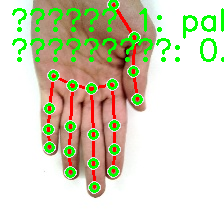


圖片: IMG_00033225.jpg
識別結果: palm
信心度: 0.91


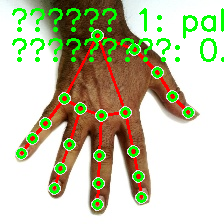


圖片: IMG_00034238.jpg
識別結果: palm
信心度: 0.96


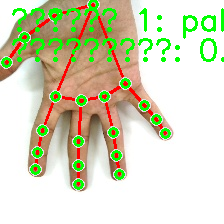


圖片: IMG_00032891.jpg
識別結果: palm
信心度: 0.93


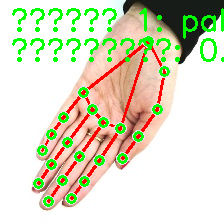


圖片: IMG_00033580.jpg
識別結果: palm
信心度: 0.94


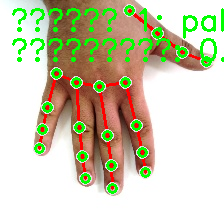


圖片: IMG_00034006.jpg
識別結果: palm
信心度: 0.88


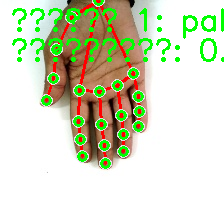


圖片: IMG_00033972.jpg
識別結果: palm
信心度: 0.89


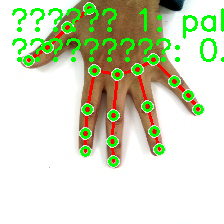


圖片: IMG_00034199.jpg
識別結果: palm
信心度: 0.90


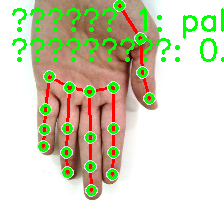


圖片: IMG_00034364.jpg
識別結果: palm
信心度: 0.97


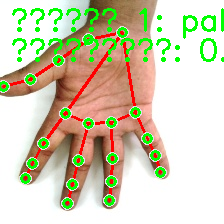


測試結果總結:
總測試圖片數: 10
成功識別圖片數: 9
識別率: 90.0%


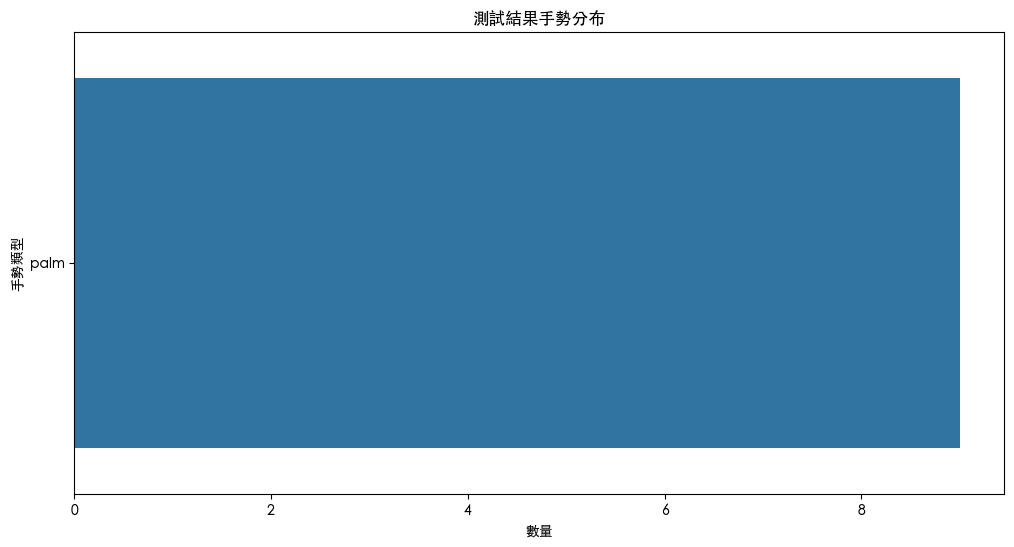

In [ ]:
# Cell 8: 主程式執行

def main():
    # 初始化混合手勢識別器
    recognizer = HybridHandGestureRecognizer()

    try:
        # 設定圖片目錄路徑
        image_dir = '/Users/zhenghongbin/Downloads/Hands ML/images/new'

        # 檢查圖片目錄是否存在
        if not os.path.exists(image_dir):
            # 若目錄不存在，拋出錯誤
            raise ValueError(f"找不到圖片目錄: {image_dir}")

        # 訓練手勢識別模型
        print("開始訓練模型...")
        X_test, y_test = recognizer.train_model(image_dir)

        # 開始處理測試圖片
        print("\n處理測試圖片...")

        # 使用 glob 模組獲取目錄中的圖片文件，僅選取前 10 張 JPG/PNG 圖片
        test_files = glob.glob(os.path.join(image_dir, '*.[jp][pn][g]'))[:10]

        # 若沒有找到測試圖片，則顯示提示並結束
        if not test_files:
            print("未找到測試圖片")
            return

        # 用來儲存測試結果的列表
        results = []

        # 逐一處理每張測試圖片
        for test_file in test_files:
            # 處理當前圖片並進行手勢識別，設定信心度閾值為 0.85
            image_rgb, gestures, confidences, status = recognizer.process_image(
                test_file,
                confidence_threshold=0.85
            )

            # 若成功識別到手勢，顯示結果
            if gestures:
                # 輸出圖片檔名
                print(f"\n圖片: {os.path.basename(test_file)}")
                # 輸出識別到的手勢及其信心度
                for gesture, confidence in zip(gestures, confidences):
                    print(f"識別結果: {gesture}")
                    print(f"信心度: {confidence:.2f}")
                # 顯示處理後的圖片
                display(Image.fromarray(image_rgb))

                # 將識別結果儲存到結果列表
                results.append({
                    'file': os.path.basename(test_file),
                    'gestures': gestures,
                    'confidences': confidences
                })

        # 顯示總結報告
        print("\n測試結果總結:")
        print(f"總測試圖片數: {len(test_files)}")
        print(f"成功識別圖片數: {len(results)}")
        print(f"識別率: {len(results)/len(test_files)*100:.1f}%")

        # 繪製結果分布圖
        if results:
            plt.figure(figsize=(12, 6))
            # 收集所有識別出的手勢類型
            all_gestures = [g for r in results for g in r['gestures']]
            # 計算每個手勢的出現次數
            gesture_counts = pd.Series(all_gestures).value_counts()
            # 畫出手勢分布的條形圖
            sns.barplot(x=gesture_counts.values, y=gesture_counts.index)
            plt.title('測試結果手勢分布')
            plt.xlabel('數量')
            plt.ylabel('手勢類型')
            # 顯示圖表
            plt.show()

    except Exception as e:
        # 若程式執行中發生錯誤，顯示錯誤訊息
        print(f"執行過程中發生錯誤: {str(e)}")
        raise e

    finally:
        # 確保在程式結束後關閉識別器
        recognizer.close()

# 執行主程式
if __name__ == "__main__":
    main()

    main()

# 9.手勢辨識系統開發總結

## 系統架構回顧

### 1. 核心組件
* **資料收集器** (HandGestureDataCollector)
  - MediaPipe 手部偵測
  - 特徵提取與增強
  - 資料集平衡處理

* **分類器** (HandGestureClassifier)
  - 集成式 SVM 分類
  - 特徵標準化
  - 自適應特徵選擇

* **整合介面** (HybridHandGestureRecognizer)
  - 模組化整合
  - 視覺化處理
  - 效能追蹤

## 2.應用價值

### 1. 實際應用場景
- 人機互動界面
- 虛擬實境控制
- 智慧家居控制

### 2. 產業應用潛力
- 教育訓練
- 安全監控
- 娛樂互動

## 3.開發心得

1. **技術層面**
   - 模組化設計的重要性
   - 錯誤處理的完整性
   - 效能優化的必要性

2. **項目管理**
   - 循序漸進的開發策略
   - 持續改進的重要性
   - 文件完整的必要性

3. **使用者導向**
   - 需求分析的重要性
   - 使用者體驗的優化
   - 系統穩定性的保證

 * 隨然時間不像專題那麼多，透過實作MediaPipe的開源套件還是有了個雛形，
 * 配合SVM分類器，合理的核函數選擇和參數優化，還是有做出來雖然能辨識設定的手勢只有5個。XD
   - 'palm',    # 手掌張開
   - 'fist',    # 握拳
   - 'thumbup', # 讚
   - 'peace',   # 勝利
   - 'ok'       # OK